[Seaborn](https://seaborn.pydata.org/) is a Python data visualization library. It provides a high-level interface for drawing attractive and informative statistical graphics.

[`scipy.optimize.minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) minimizes scalar function of one or more variables.

In [468]:
import math
# !pip install latexify-py
import latexify
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.optimize as so
np.random.seed(0)

## Maximum Likelihood Example - Laplace Distribution

In [469]:
# Generate data
n = 10001
normalData = pd.DataFrame({"NormalData": pd.Series(np.random.normal(0, 1, n))})
laplaceData = pd.DataFrame({"LaplaceData": pd.Series(np.random.laplace(0,  1/np.sqrt(2), n))})
                                                                       #Location parameter
                                                                           #scale parameter defining wideness (the choice used here gives the same variance
                                                                           #as normal distribution with variance 1)   

df = pd.concat([normalData, laplaceData], axis=1)
df.tail()

,NormalData,LaplaceData
9996,0.042359,-0.203818
9997,0.516872,0.070830
9998,-0.032921,-0.118174
9999,1.298111,-1.406202
10000,-0.202117,0.418847


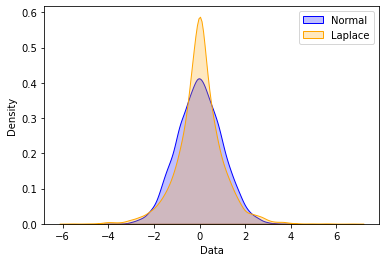

In [470]:
# Plot
sns.kdeplot(df['NormalData'], fill=True, color='Blue', label='Normal')
sns.kdeplot(df['LaplaceData'], fill=True, color='Orange', label='Laplace')
plt.xlabel('Data')
plt.legend()
plt.show()

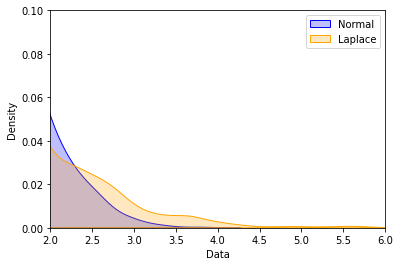

In [471]:
#Zoom in
sns.kdeplot(df['NormalData'], fill=True, color='Blue', label='Normal')
sns.kdeplot(df['LaplaceData'], fill=True, color='Orange', label='Laplace')
plt.xlabel('Data')
plt.xlim(2,6)
plt.ylim(0,0.1)
plt.legend()
plt.show()
# You see more extreme values with Laplace even with the same variance. The Laplace
# distribution is useful for modeling data where more extreme values are expected.

The likelihood of the data is the product of the probability density function evaluated at each one of the data points. So, we really want to know what is the probability density function of the [Laplace distribution](https://en.wikipedia.org/wiki/Laplace_distribution).

Negative, because Scipy gives us a minimization function. So we are going to minimize the negative log likelihood to get the maximum log likelihood. Recall: We do log to avoid getting underflow to zero.

In [472]:
# Laplace Negative Log Likelihood
def laplaceNegLogLikelihood(mu, b, y):
    neg_log_lik = -(-np.log(2*b)-(1/b)*np.sum(abs(y-mu)))
    return neg_log_lik

# Let's latexify the Laplace Negative Log Likelihood function
@latexify.with_latex
def L(mu, b, y): 
    return -(-log(2*b)-(1/b)*sum(abs(y-mu)))
L

<latexify.core.with_latex.<locals>._LatexifiedFunction at 0x7f54ea34a250>

Develop a maximum likelihood function that takes a set of data and produces the maximum likelihood estimate for the mean of those data: 

In [483]:
## Laplace Maximum Likelihood Estimate for mu
def maximumLikelihood(y):                      
    RES = so.minimize(laplaceNegLogLikelihood, 1, args=(1, y), method="Powell", tol = 1e-8) # Powell works better for functions that are not differentiable everywhere
    # print(RES)
    return RES.x.round(4)

# Test the function
maximumLikelihood(df.LaplaceData.values)

array([0.0016])

which is very close to zero set for the original data.

In [484]:
# Minimizing the sum of absolute differences should be the same as median:
round(df.LaplaceData.median(),4)

0.0016

In [475]:
# Laplace Negative Log Likelihood for regression
def laplaceRegNegLogLikelihood(beta, X, y):
    mu = (X@beta).reshape(-1,1) # compute the mean that we would have if assumed that the form of the function of the mean is beta times X
                                # in other words, Assuming y is distributed with mean b0+b1*X (i.e. X@beta) 
    return laplaceNegLogLikelihood(mu, 1, y)

So, now if we want the maximum likelihood estimated at the regression coefficients we are going to write a function that takes in the X's and the Y's and then optimizes `laplaceRegNegLogLikelihood` to find the betas that are the maximum likelihood estimates for vector beta.  

In [476]:
# Function to maximize regression log likelihood
def maximumRegLikelihood(X, y, negloglik=laplaceRegNegLogLikelihood):
    nrows, ncols = X.shape
    betas=np.zeros((ncols,1)) # initialize vector beta
    RES = so.minimize(negloglik, betas, args=(X,y), method="Powell", tol=1e-8) 
    print(RES.x)
    return RES.x

Let's test this out:

In [477]:
run_data = pd.read_csv("RunningSpeeds.csv")
run_data.head()

,Unnamed: 0,age,pace
0,0,38,3.73
1,1,75,7.53
2,2,35,4.73
3,3,27,4.26
4,4,54,5.40


In [478]:
x_train = run_data.age.values
X_train = np.c_[np.ones(x_train.size), x_train]
y_train = run_data.pace.values.reshape(-1,1)

betas = maximumRegLikelihood(X_train, y_train)

[3.33521739 0.03434783]


/tmp/ipykernel_660138/2109103071.py:5: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  RES = so.minimize(negloglik, betas, args=(X,y), method="Powell", tol=1e-8)


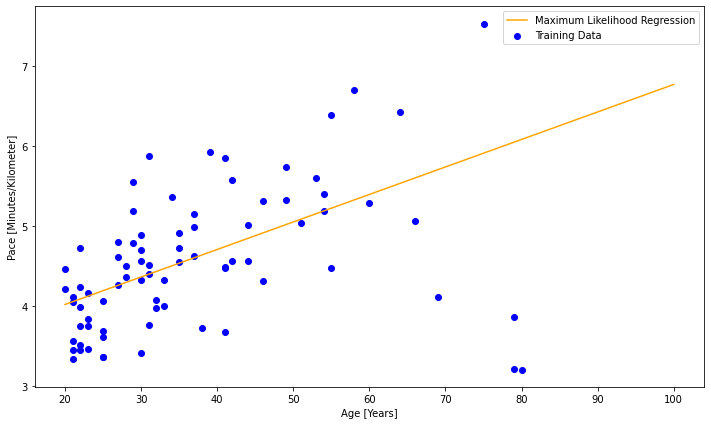

In [479]:
x_new = np.linspace(run_data.age.values.min(), run_data.age.values.max()+20, 100)
X_new = np.c_[np.ones(x_new.size), x_new]
y_predicted = X_new@betas

fig, ax = plt.subplots()
fig.set_size_inches(12, 7)
plt.scatter(x_train, y_train, c='blue', label='Training Data')
plt.plot(x_new, y_predicted, c='orange', label='Maximum Likelihood Regression')
plt.legend()
plt.xlabel("Age [Years]")
plt.ylabel("Pace [Minutes/Kilometer]")
plt.show()

Let's compare the data actual distributions against some ideal distributions:

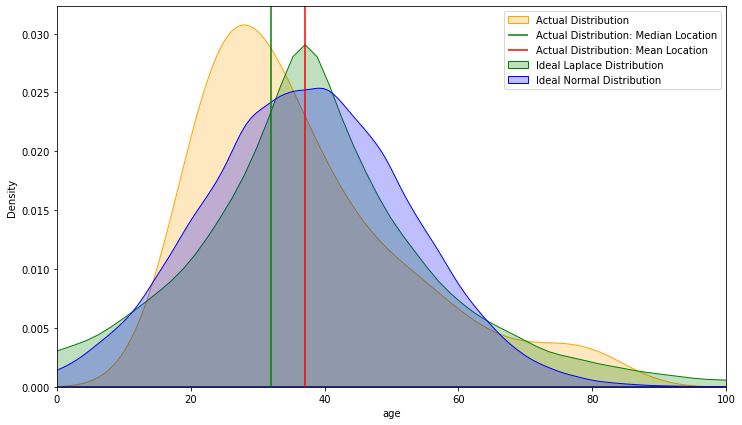

In [480]:
data = run_data['age']

fig, ax = plt.subplots()
fig.set_size_inches(12, 7)

sns.kdeplot(data, fill=True, color='Orange', label='Actual Distribution')
ylim = ax.get_ylim()
plt.vlines(data.median(), ylim[0], ylim[1], color='green', label='Actual Distribution: Median Location')
plt.vlines(data.mean(), ylim[0], ylim[1], color='red', label='Actual Distribution: Mean Location')

sns.kdeplot(np.random.laplace(data.mean(), data.std(), 100000), fill=True, color='Green', label='Ideal Laplace Distribution')
sns.kdeplot(np.random.normal(data.mean(), data.std(), 100000), fill=True, color='Blue', label='Ideal Normal Distribution')

plt.xlim(0,100)
plt.ylim(ylim)
plt.legend()
plt.show()

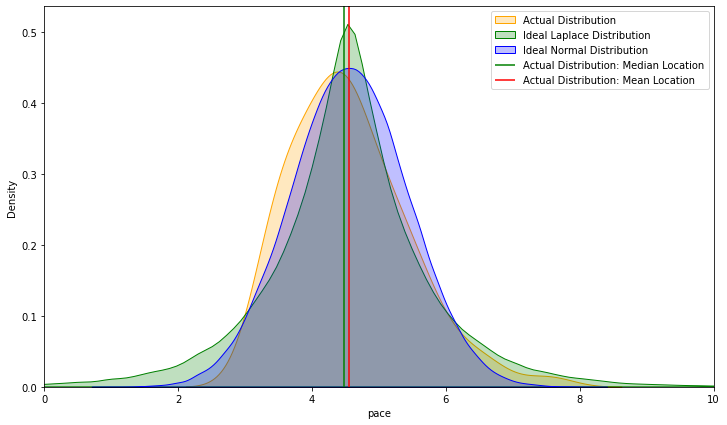

In [481]:
data = run_data['pace']

fig, ax = plt.subplots()
fig.set_size_inches(12, 7)

sns.kdeplot(data, fill=True, color='Orange', label='Actual Distribution')
sns.kdeplot(np.random.laplace(data.mean(), data.std(), 100000), fill=True, color='Green', label='Ideal Laplace Distribution')
ylim = ax.get_ylim()
sns.kdeplot(np.random.normal(data.mean(), data.std(), 100000), fill=True, color='Blue', label='Ideal Normal Distribution')

plt.vlines(data.median(), ylim[0], ylim[1], color='green', label='Actual Distribution: Median Location')
plt.vlines(data.mean(), ylim[0], ylim[1], color='red', label='Actual Distribution: Mean Location')
plt.xlim(0,10)
plt.ylim(ylim)
plt.legend()
plt.show()

Which ideal distribution is a better choice to represent the actual data?